# AUTOMATIC TICKET CLASSIFICATION CASE STUDY

## Customer Complaint Classification System
## Problem Statement
In the dynamic landscape of customer support, efficient handling of customer complaints is crucial for maintaining customer satisfaction and loyalty. Our company has amassed a substantial amount of customer complaint data in JSON format. Unfortunately, this data is currently unlabelled, making it challenging to promptly route tickets to the appropriate departments for resolution. To address this issue, we propose the implementation of a robust classification system using Natural Language Processing (NLP) techniques.

**Objective**
:The goal is to create a model capable of automatically categorizing customer complaints into distinct clusters based on the products or services mentioned in the tickets. This classification will allow for streamlined ticket management, ensuring that each issue is directed to the relevant department for swift and effective resolution.

**classify tickets into the following five clusters based on their products/services:**

Credit card / Prepaid card

Bank account services

Theft/Dispute reporting

Mortgages/loans

Others

In [1]:
# Importing required library
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing libraries for text preprocessing and analysis
import re, nltk, spacy, string
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Importing libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Libraries for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

# Row/Column display limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

C:\Users\asus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### The libraries are imported for basic numerical computation, data manipulation, data visualization, text preprocessing and analysis and model evaluation. The library spacy is used for production purpose. Known for speed and efficiency. Key features are tokenization, POS tag, named entity recogniton, lemmatization. NMF is non negative matrix factorization used for dimensionality reduction for topic modelling and feature extraction. Textblob is NLP lib built on top of NLTK provides cosistent API for NLP tasks and easy to use for text processing and analysis. Wordcloud is a data visualization tech. that displays most frequent words in the text. Generates visually appearing wordclouds, excludes stopwords from display. 

In [2]:
# Loading the data
f = open('C:\\Users\\asus\\Desktop\\Automatic Ticket Classification\\Dataset\\complaints-2021-05-14_08_16 (1).json')
data = json.load(f)
df = pd.json_normalize(data)
df.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state _source.consumer_disputed  \
0  2019-04-13T12:00:00-05:00            CA                       N/A   
1  2019-05-01T12:00:00-05:00            GA                       N/A   
2  2019-04-02T12:00:00-05:00            TX                       N/A   
3  2017-09-13T12:00:00-05:00            MI                       N/A   
4  2019-04-05T12:00:00-05:00            NY                       N/A   

               _source.product _source.company_response       _source.company  \
0              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
1              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
2  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.   
3                     Mortgage  Closed with explanation  JPMORGAN CHASE & CO.   
4  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.   

  _source.submitted_via _source.date_sent_to_company  \
0                   Web    2019-04-13T12:00:00-05:00   
1                   Web    2019-05-01T12:00:00-05:00   
2                   Web    2019-04-02T12:00:00-05:00   
3                   Web    2017-09-14T12:00:00-05:00   
4              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely  \
0            Yes   
1            Yes   
2            Yes   
3            Yes   
4            Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                              _source.complaint_what_happened  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to vali

### The above code loads the json data and convert it to pandas dataframe. The opened json data is parsed to python data structures. The json normalize flattens the data such that nested dictionaries are expanded into seperate tables. The resulting data from json.load is dictionary/list or combination.

In [3]:
# Checking the shape of data
df.shape

(78313, 22)

### No of rows: 78313
### No of columns: 22

In [4]:
# Checking the info about datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
# Checking the statistical distribution of data
df.describe().T

count  mean  std  min  25%  50%  75%  max
_score  78313.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
# Checking the null values present in data
(df.isnull().sum()/df.shape[0])*100

_index                                0.000000
_type                                 0.000000
_id                                   0.000000
_score                                0.000000
_source.tags                         86.081493
_source.zip_code                      8.628197
_source.complaint_id                  0.000000
_source.issue                         0.000000
_source.date_received                 0.000000
_source.state                         2.542362
_source.consumer_disputed             0.000000
_source.product                       0.000000
_source.company_response              0.000000
_source.company                       0.000000
_source.submitted_via                 0.000000
_source.date_sent_to_company          0.000000
_source.company_public_response      99.994892
_source.sub_product                  13.498397
_source.timely                        0.000000
_source.complaint_what_happened       0.000000
_source.sub_issue                    59.117899
_source.consu

In [7]:
df.head(20)

_index      _type      _id  _score    _source.tags  \
0   complaint-public-v2  complaint  3211475     0.0            None   
1   complaint-public-v2  complaint  3229299     0.0   Servicemember   
2   complaint-public-v2  complaint  3199379     0.0            None   
3   complaint-public-v2  complaint  2673060     0.0            None   
4   complaint-public-v2  complaint  3203545     0.0            None   
5   complaint-public-v2  complaint  3275312     0.0  Older American   
6   complaint-public-v2  complaint  3238804     0.0            None   
7   complaint-public-v2  complaint  3249272     0.0            None   
8   complaint-public-v2  complaint  3351653     0.0            None   
9   complaint-public-v2  complaint  3273612     0.0            None   
10  complaint-public-v2  complaint  3233499     0.0            None   
11  complaint-public-v2  complaint  3180294     0.0            None   
12  complaint-public-v2  complaint  3362102     0.0            None   
13  complaint-public-v2  complaint  3319930     0.0            None   
14  complaint-public-v2  complaint  3224980     0.0            None   
15  complaint-public-v2  complaint  3209411     0.0            None   
16  complaint-public-v2  complaint  3311133     0.0            None   
17  complaint-public-v2  complaint  3331023     0.0            None   
18  complaint-public-v2  complaint  2647668     0.0            None   
19  complaint-public-v2  complaint  3300211     0.0            None   

   _source.zip_code _source.complaint_id  \
0             90301              3211475   
1             319XX              3229299   
2             77069              3199379   
3             48066              2673060   
4             10473              3203545   
5             48227              3275312   
6             76262              3238804   
7             07753              3249272   
8             60621              3351653   
9             99354              3273612   
10            104XX              3233499   
11            750XX              3180294   
12            08701              3362102   
13            420XX              3319930   
14            920XX              3224980   
15             None              3209411   
16            78748              3311133   
17            770XX              3331023   
18            47331              2647668   
19            32796              3300211   

                           _source.issue      _source.date_received  \
0      Attempts to collect debt not owed  2019-04-13T12:00:00-05:00   
1        Written notification about debt  2019-05-01T12:00:00-05:00   
2     Other features, terms, or problems  2019-04-02T12:00:00-05:00   
3         Trouble during payment process  2017-09-13T12:00:00-05:00   
4                       Fees or interest  2019-04-05T12:00:00-05:00   
5                    Managing an account  2019-06-13T12:00:00-05:00   
6                    Managing an account  2019-05-10T12:00:00-05:00   
7         Trouble during payment process  2019-05-15T12:00:00-05:00   
8                     Closing an account  2019-08-22T12:00:00-05:00   
9                    Managing an account  2019-06-11T12:00:00-05:00   
10  Incorrect information on your report  2019-05-06T12:00:00-05:00   
11  Incorrect information on your report  2019-03-14T12:00:00-05:00   
12                    Closing an account  2019-09-04T12:00:00-05:00   
13  Incorrect information on your report  2019-07-26T12:00:00-05:00   
14                   Managing an account  2019-04-27T12:00:00-05:00   
15           Improper use of your report  2019-04-11T12:00:00-05:00   
16                   Managing an account  2019-07-17T12:00:00-05:00   
17                    Closing an account  2019-08-06T12:00:00-05:00   
18            Struggling to pay mortgage  2017-08-22T12:00:00-05:00   
19       Written notification about debt  2019-07-09T12:00:00-05:00   

   _source.state _source.consumer_disputed  \
0             CA                       N/A   
1             GA

### The column _source.complaint_what_happened has multiple blanck values. Need to replace these empty spaces with nan.

In [8]:
# Replacing empty spaces of _source.complaint_what_happened column with nan
df['_source.complaint_what_happened'].replace('', np.nan, inplace=True)

# Checking the null count again
(df.isnull().sum()/df.shape[0])*100

_index                                0.000000
_type                                 0.000000
_id                                   0.000000
_score                                0.000000
_source.tags                         86.081493
_source.zip_code                      8.628197
_source.complaint_id                  0.000000
_source.issue                         0.000000
_source.date_received                 0.000000
_source.state                         2.542362
_source.consumer_disputed             0.000000
_source.product                       0.000000
_source.company_response              0.000000
_source.company                       0.000000
_source.submitted_via                 0.000000
_source.date_sent_to_company          0.000000
_source.company_public_response      99.994892
_source.sub_product                  13.498397
_source.timely                        0.000000
_source.complaint_what_happened      73.092590
_source.sub_issue                    59.117899
_source.consu

In [9]:
# Dropping nulls from '_source.complaint_what_happened' column
df.dropna(subset=['_source.complaint_what_happened'], inplace=True)

# Checking the shape of data
df.shape

(21072, 22)

In [10]:
# Removing _ and source from columns
df.columns = [re.sub(r'^_', '', col) for col in df.columns]
df.columns = [re.sub(r'^source\.', '', col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [11]:
# Define a function that gives text input and returns cleaned text
def cleaned_text(text):
    text = text.lower()  # Making lowercase chr
    text = re.sub(r'\[.*?\]', '', text)  # Remove shortest possible text enclosed in square bracket
    text = re.sub(r'[%s]'%re.escape(string.punctuation), '', text)  # Remove punctuation marks, escape from spacial chr 
    text = re.sub(r'\w*\d\w*', '', text)  # Remove alphanumeric chrs
    return text

In [12]:
# Lets clean the text from '_source.complaint_what_happened' column
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: cleaned_text(x))

In [13]:
# Define a function that returns lemmatized text 
def lemmatize_text(text):
    lemma_list = []
    document = nlp(text)
    for word in document:     # Extract lemmas (base word) for text and add it to list
        lemma_list.append(word.lemma_)
    return ' '.join(lemma_list)

In [14]:
# Apply the above function to complaint_what_happened column and add new column to df 'lemmatized_complaints'
df['lemmatized_complaints'] = df.apply(lambda x: lemmatize_text(x['complaint_what_happened']), axis=1)

df.head()

index       type       id  score           tags zip_code  \
1   complaint-public-v2  complaint  3229299    0.0  Servicemember    319XX   
2   complaint-public-v2  complaint  3199379    0.0           None    77069   
10  complaint-public-v2  complaint  3233499    0.0           None    104XX   
11  complaint-public-v2  complaint  3180294    0.0           None    750XX   
14  complaint-public-v2  complaint  3224980    0.0           None    920XX   

   complaint_id                                 issue  \
1       3229299       Written notification about debt   
2       3199379    Other features, terms, or problems   
10      3233499  Incorrect information on your report   
11      3180294  Incorrect information on your report   
14      3224980                   Managing an account   

                date_received state consumer_disputed  \
1   2019-05-01T12:00:00-05:00    GA               N/A   
2   2019-04-02T12:00:00-05:00    TX               N/A   
10  2019-05-06T12:00:00-05:00    NY               N/A   
11  2019-03-14T12:00:00-05:00    TX               N/A   
14  2019-04-27T12:00:00-05:00    CA               N/A   

                                                                         product  \
1                                                                Debt collection   
2                                                    Credit card or prepaid card   
10  Credit reporting, credit repair services, or other personal consumer reports   
11  Credit reporting, credit repair services, or other personal consumer reports   
14                                                   Checking or savings account   

           company_response               company submitted_via  \
1   Closed with explanation  JPMORGAN CHASE & CO.           Web   
2   Closed with explanation  JPMORGAN CHASE & CO.           Web   
10  Closed with explanation  JPMORGAN CHASE & CO.           Web   
11  Closed with explanation  JPMORGAN CHASE & CO.           Web   
14  Closed with explanation  JPMORGAN CHASE & CO.           Web   

         date_sent_to_company company_public_response  \
1   2019-05-01T12:00:00-05:00                    None   
2   2019-04-02T12:00:00-05:00                    None   
10  2019-05-06T12:00:00-05:00                    None   
11  2019-03-15T12:00:00-05:00                    None   
14  2019-04-27T12:00:00-05:00                    None   

                                   sub_product timely  \
1                             Credit card debt    Yes   
2   General-purpose credit card or charge card    Yes   
10              Other personal consumer report    Yes   
11                            Credit reporting    Yes   
14                            Checking account    Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [15]:
# Create a new df 'cleaned_df' which have only 2 columns complaint_what_happened and lemmatized_complaints
cleaned_df = df[['complaint_what_happened', 'lemmatized_complaints']]
cleaned_df.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [16]:
# Extracting POS tag
def singular_noun(text):
    text_blob = TextBlob(text)
    return ' '.join([word for (word,tag) in text_blob.tags if tag=='NN'])

import nltk
nltk.download('averaged_perceptron_tagger')

### The avg perceptron tagger is a POS tagger used for assigning POS tags to each word of sentence. It uses perceptron ML algorithm to predict POS tags for words. It provides info about gramatical structure of sentence.

import nltk
nltk.download('punkt')

### The punkt is pretrained unsupervised ML model for sentence tokenize.

In [85]:
# Adding new column 'complaints_POS_removed' to cleaned_df after removing POS tag from lemmatized_complaints
cleaned_df['complaints_POS_removed'] = df.apply(lambda x: singular_noun(x['lemmatized_complaints']), axis=1)

cleaned_df.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Exploratory Data Analysis

In [86]:
# Visualize the data from complaints_POS_removed column based on character length
chr_len = [len(x) for x in cleaned_df['complaints_POS_removed']]
chr_len[:10]

[159, 105, 74, 414, 161, 7, 629, 605, 1186, 51]

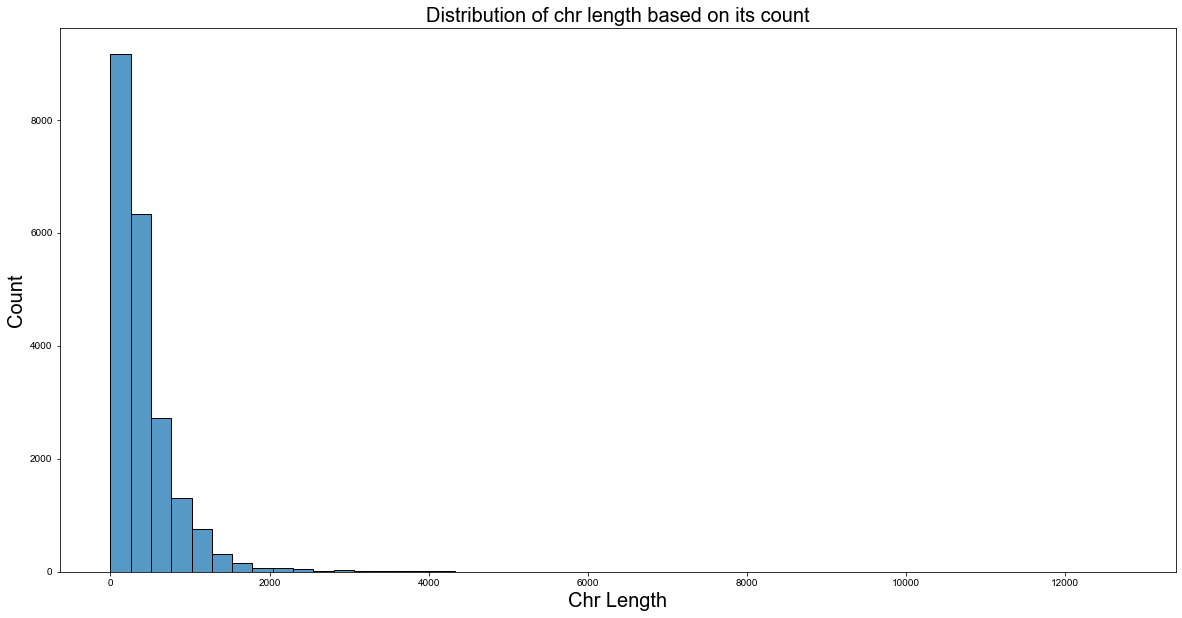

In [87]:
# Plot the histogram based on chr length
plt.figure(figsize=[20,10])
sns.histplot(data=chr_len, bins=50)
plt.title('Distribution of chr length based on its count', fontdict={'fontsize':20})
plt.xlabel('Chr Length', fontdict={'fontsize':20})
plt.ylabel('Count', fontdict={'fontsize':20})
plt.show()

In [88]:
# Removing pronouns from text corpus complaints_POS_removed
cleaned_df['complaints_clean'] = cleaned_df['complaints_POS_removed'].str.replace('-PRON-', '')

In [89]:
# Find top 30 unigrams along with their frequency in 'complaints_POS_removed' corpus 
def top30unigrams(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    BOW_model = vector.transform(text)
    BOW_model_sum = BOW_model.sum(axis=0)
    word_freq = [(word, BOW_model_sum[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq = sorted(word_freq, key= lambda x: x[1], reverse=True)
    return word_freq[:n]

### The function top30unigrams learns the vocabulary from input text data and then transform this data into matrix form where each row represents documents in text data and column represents a unique word in vocabulary. stopwords are removed during learning process. The function returns top 30 single words along with their frequency.

In [90]:
# Top 30 unigrams in complaints_POS_removed
top30uni = top30unigrams(cleaned_df['complaints_POS_removed'].values.astype('U'))
top30uni_df = pd.DataFrame(top30uni, columns=['unigrams', 'counts'])
top30uni_df.head()

unigrams  counts
0  account   47514
1    chase   46699
2     xxxx   36563
3   credit   34148
4     card   29278

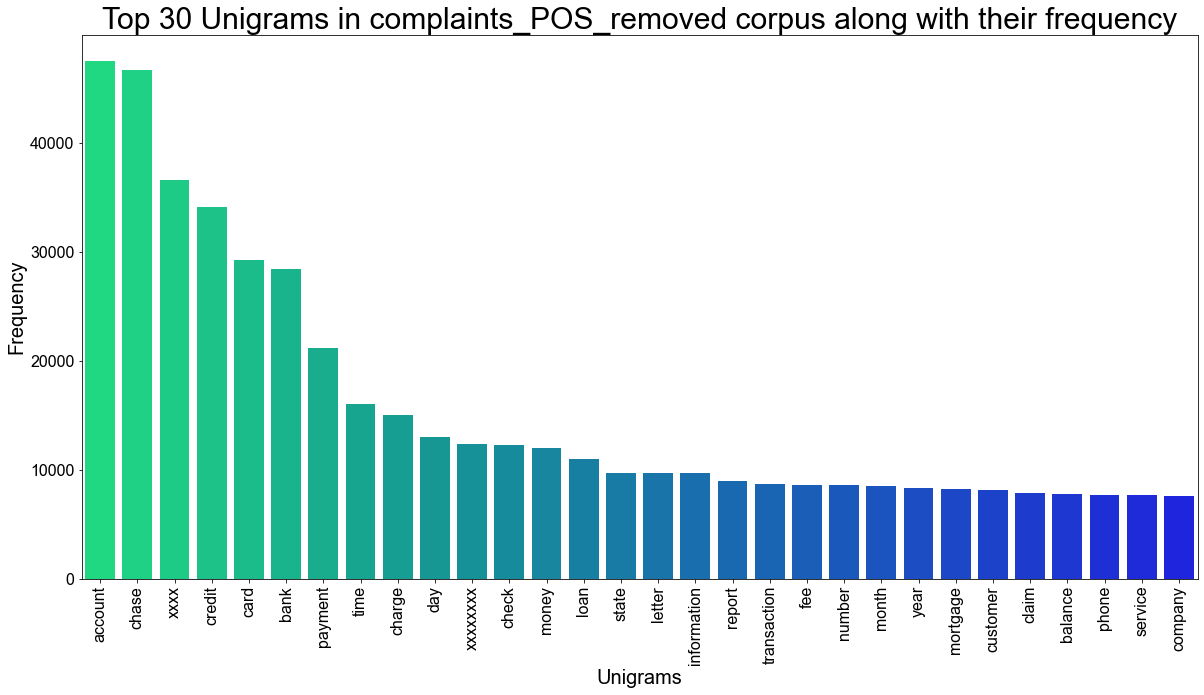

In [91]:
# Lets plot the barplot of top 30 unigrams
plt.figure(figsize=[20,10])
sns.barplot(x=top30uni_df['unigrams'], y=top30uni_df['counts'], palette='winter_r')
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Unigrams', fontdict={'fontsize':20})
plt.ylabel('Frequency', fontdict={'fontsize':20})
plt.title('Top 30 Unigrams in complaints_POS_removed corpus along with their frequency', fontdict={'fontsize':30})
plt.show()

In [92]:
# Find top 30 bigrams along with their frequency in 'complaints_POS_removed' corpus 
def top30bigrams(text, n=30):
    vector = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(text)
    BOW_model = vector.transform(text)
    BOW_model_sum = BOW_model.sum(axis=0)
    word_freq = [(word, BOW_model_sum[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq = sorted(word_freq, key= lambda x: x[1], reverse=True)
    return word_freq[:n]

### The count vectorizer is initialized with ngram range as (2,2) means it finds the bigrams from input text data. The first parameter 2 is min range and second one is max.

In [93]:
# Top 30 bigrams in complaints_POS_removed
top30bi = top30bigrams(cleaned_df['complaints_POS_removed'].values.astype('U'))
top30bi_df = pd.DataFrame(top30bi, columns=['Bigrams', 'counts'])
top30bi_df.head()

Bigrams  counts
0       credit card   12778
1     credit report    3955
2         xxxx xxxx    3953
3  customer service    3081
4      chase credit    2966

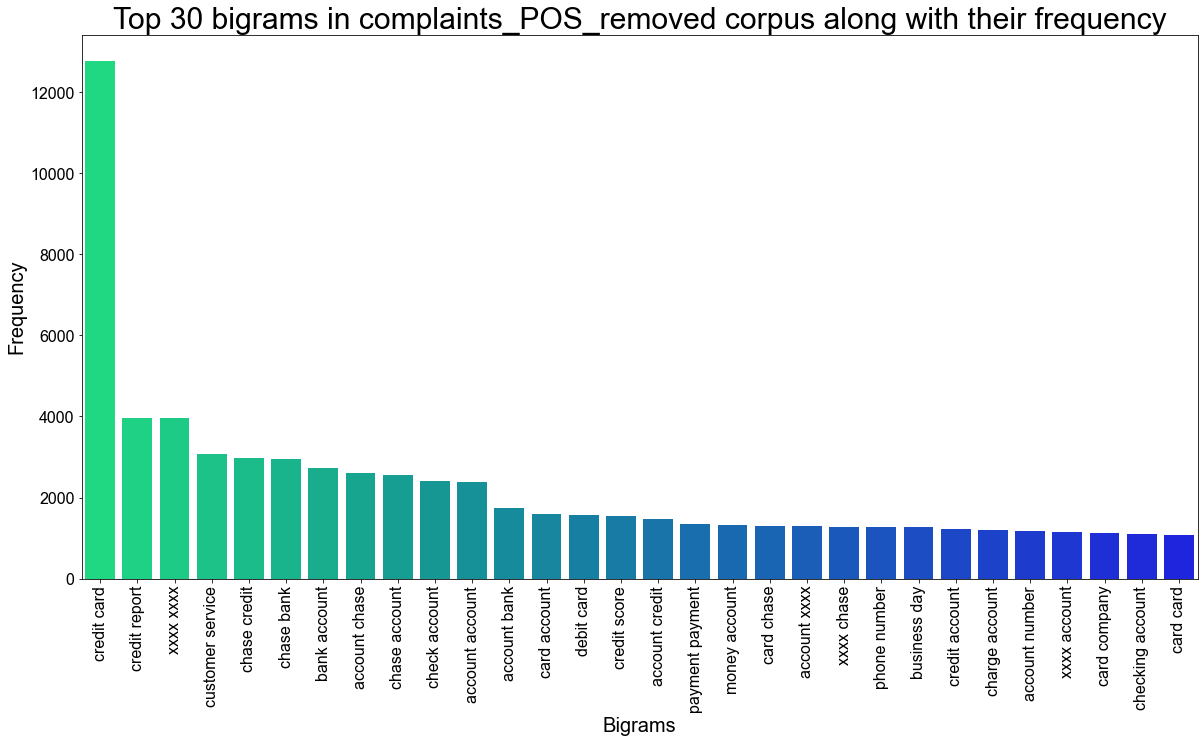

In [94]:
# Lets plot the barplot of top 30 bigrams
plt.figure(figsize=[20,10])
sns.barplot(x=top30bi_df['Bigrams'], y=top30bi_df['counts'], palette='winter_r')
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Bigrams', fontdict={'fontsize':20})
plt.ylabel('Frequency', fontdict={'fontsize':20})
plt.title('Top 30 bigrams in complaints_POS_removed corpus along with their frequency', fontdict={'fontsize':30})
plt.show()

In [95]:
# Find top 30 trigrams along with their frequency in 'complaints_POS_removed' corpus 
def top30trigrams(text, n=30):
    vector = CountVectorizer(ngram_range=(3,3), stop_words='english').fit(text)
    BOW_model = vector.transform(text)
    BOW_model_sum = BOW_model.sum(axis=0)
    word_freq = [(word, BOW_model_sum[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq = sorted(word_freq, key= lambda x: x[1], reverse=True)
    return word_freq[:n]

In [96]:
# Top 30 trigrams in complaints_POS_removed
top30tri = top30trigrams(cleaned_df['complaints_POS_removed'].values.astype('U'))
top30tri_df = pd.DataFrame(top30tri, columns=['Trigrams', 'counts'])
top30tri_df.head()

Trigrams  counts
0    chase credit card    2063
1  credit card account    1022
2  credit card company     991
3    credit card chase     633
4   credit card credit     513

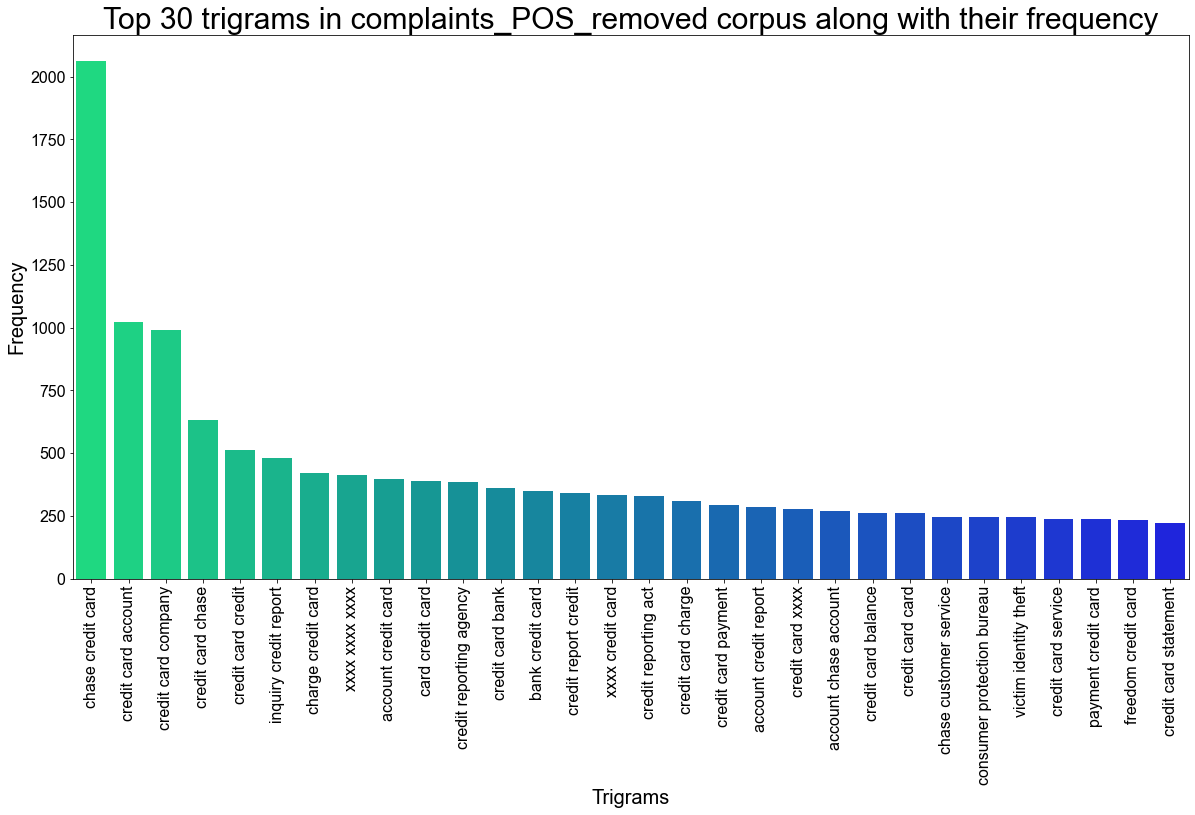

In [97]:
# Lets plot the barplot of top 30 trigrams
plt.figure(figsize=[20,10])
sns.barplot(x=top30tri_df['Trigrams'], y=top30tri_df['counts'], palette='winter_r')
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Trigrams', fontdict={'fontsize':20})
plt.ylabel('Frequency', fontdict={'fontsize':20})
plt.title('Top 30 trigrams in complaints_POS_removed corpus along with their frequency', fontdict={'fontsize':30})
plt.show()

In [98]:
# Remove the personnel info of the customer masked as xxxx in complaints_POS_removed corpus
cleaned_df['complaints_clean'] = cleaned_df['complaints_clean'].str.replace('xxxx', '')
cleaned_df.shape

(21072, 4)

In [99]:
cleaned_df.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [100]:
# Feature Extraction using TfIdf Vectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
DTM = tfidf.fit_transform(cleaned_df['complaints_POS_removed'])

### TfIdf model is used for info retrieval and text mining to represent how important the word is to document or whole corpus. The max doc freq is set to 0.95 means the words occur more than 95% in documents ie too common are excluded and the words that are too rare occur less than 2 doc are also excluded. This controls the size and relevance of vocabulary.

In [101]:
# Initialize the NMF model with no of topics 5
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(DTM)

NMF(n_components=5, random_state=42)

In [105]:
# Checking the features obtained from tfidf model
len(tfidf.get_feature_names_out())

7364

In [107]:
# Lets find the top 10 words with highest weights from nmf model and sort it in ascending order
first_topic = nmf_model.components_[0]
top10words_idx = first_topic.argsort()[-10:]
for index in top10words_idx:
    print(tfidf.get_feature_names_out()[index])

day
branch
xxxx
deposit
chase
fund
money
bank
check
account


### The above words are the indicative of most imp terms associated with perticular topic.

In [110]:
# Lets print the top 15 words from each topic
for index, topic in enumerate(nmf_model.components_):
    print(f'Top 15 words from Topic #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words from Topic #0
['customer', 'transfer', 'transaction', 'business', 'number', 'day', 'branch', 'xxxx', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


Top 15 words from Topic #1
['letter', 'year', 'balance', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


Top 15 words from Topic #2
['foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'xxxx', 'mortgage', 'loan']


Top 15 words from Topic #3
['refund', 'time', 'service', 'xxxxxxxx', 'purchase', 'fraud', 'claim', 'merchant', 'xxxx', 'fee', 'dispute', 'chase', 'transaction', 'card', 'charge']


Top 15 words from Topic #4
['chase', 'account', 'credit', 'xxxx', 'pay', 'date', 'auto', 'time', 'xxxxxxxx', 'day', 'statement', 'fee', 'month', 'balance', 'payment']




### These are the top 15 words present in each topic having highest weights.

In [111]:
# Create best topic for each of the complaint in terms of int 0,1,2,3,4
best_topic = nmf_model.transform(DTM) # Extracting the topic wts for each complaint
best_topic[0].round(2) 
best_topic[0].argmax()  # Dominant topic for first complaint
best_topic.argmax(axis=1) # Domnant topic for all complaints

array([0, 3, 1, ..., 3, 4, 4], dtype=int64)

### The DTM is transformed using fitted nmf model resulting a matrix where each row consist of complaints(words) and each column consist of weight of that complaint in each topic to find the best topic. The first complaint of best topic is rounded to 2 decimal places and finds the index of the topic having highest wts for first complaint. The index of the topic having highest wts of each complaint s then found. It operates over rows and provides an array of ints representing the dominant topic for corrosponding complaints.

In [112]:
# Assign the best topic for each of the complaint in cleaned df
cleaned_df['Best Topic'] = best_topic.argmax(axis=1)
cleaned_df.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [114]:
# Now we will use the index of topics to classify any new complaint. Lets create training df using complaint_what_happened
training_df = cleaned_df[['complaint_what_happened', 'Best Topic']]
training_df.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [115]:
# Checking the value counts of topics 
training_df['Best Topic'].value_counts()

3    5128
0    5084
1    4856
2    3807
4    2197
Name: Best Topic, dtype: int64

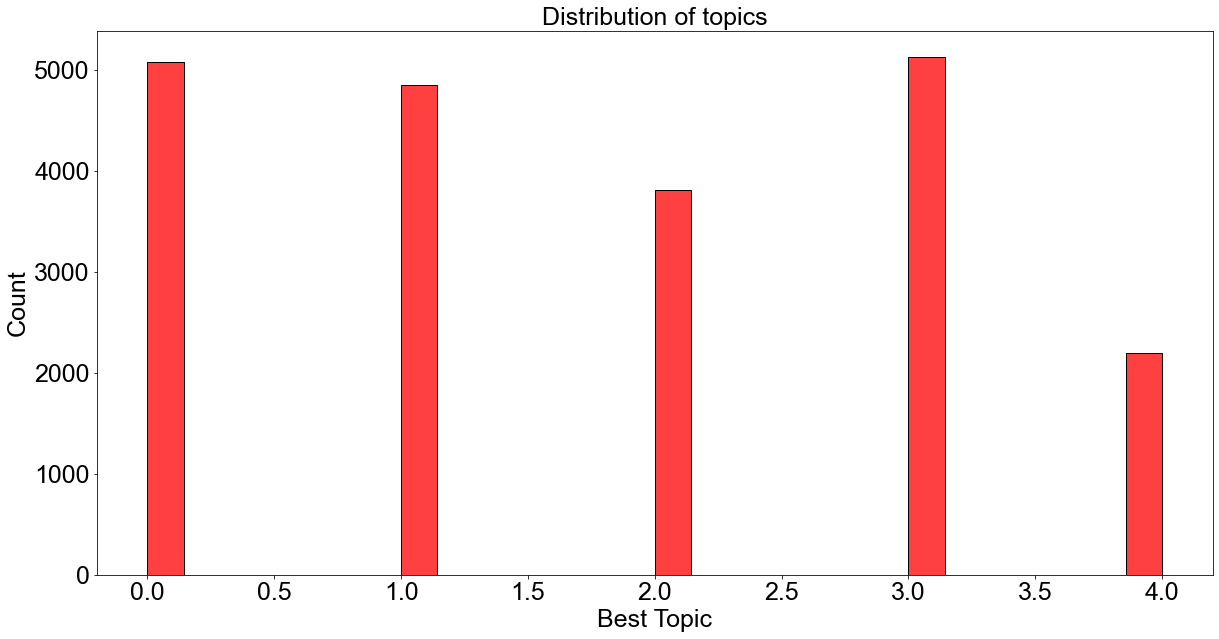

In [118]:
# Visualize the distribution of topics using histplot
plt.figure(figsize=[20,10])
sns.histplot(data=training_df, x='Best Topic', color='r')
plt.title('Distribution of topics', fontsize=25)
plt.xlabel('Best Topic', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()3

### Lets initialize the BOW model to get the matrix representation of input text based on token counts. The BOW model considers only the unique word (feature/vocabulary) from all the docs present in text data. It will not consider the order of words in docs and importance of word wrt whole corpus. It gives same importance to all words. Therefore we have to further use tfidf representation to get the frequency info from BOW model with imporatnce info. It takes into account not only frequency of word in the docs but also how unique that word is across all docs. This helps in giving more weights to words that are imp for spacific doc but not too common across entire corpus.

In [119]:
# BOW model 
BOW_model = CountVectorizer()
X_train_BOW = BOW_model.fit_transform(training_df['complaint_what_happened'])

In [120]:
# TFIDF model
tfidf_model = TfidfTransformer()
X_train_tfidf = tfidf_model.fit_transform(X_train_BOW)

In [186]:
# Lets do the train test split 
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_df['Best Topic'], test_size=0.25, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (15804, 33599)
X_test shape: (5268, 33599)
y_train shape: (15804,)
y_test shape: (5268,)


In [187]:
# Lets create the model evaluation function for choosing the best model
def model_evaluation(y_test, y_pred, model_name):
    print(f'Classification Report {model_name}\n')
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", 
                                                              "Others", "Theft/Dispute Reporting","Mortgage/Loan"]))
    
    plt.figure(figsize=[20,10])
    plt.title(f'Confusion matrix {model_name}\n', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Greens', xticklabels=["Bank Account services", "Credit card or prepaid card", 
                                                              "Others", "Theft/Dispute Reporting","Mortgage/Loan"],
                yticklabels=["Bank Account services", "Credit card or prepaid card", 
                                                              "Others", "Theft/Dispute Reporting","Mortgage/Loan"], 
                annot_kws={"size": 20}, fmt='d')
    
    plt.show()

### The function will print the classification report along with the heatmap of confusion matrix.

## 1) Naive Bayes

In [188]:
# Importing the NB alogorithm from sklearn
from sklearn.naive_bayes import MultinomialNB

# Initializing NB algorithm, fitting the training data and predicting on test data
model_name = 'NB'
NB = MultinomialNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

In [189]:
# Calculating the f1 score of model using weighted avg method
F1_score_NB = f1_score(y_test, y_pred, average='weighted')
F1_score_NB

0.6844028768108159

### The descent f1 score is achieved without hyperparameters. Lets train hyperparameteres using grid search CV.

In [190]:
# Hyperparameter training
params_NB = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
            'fit_prior': [True, False]} 

gridCV_NB = GridSearchCV(estimator=NB, param_grid=params_NB, scoring='f1_weighted', verbose=1, n_jobs=-1, cv=5)
gridCV_NB.fit(X_train, y_train)
gridCV_NB.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'alpha': 0.1, 'fit_prior': False}

In [191]:
# Creating model with best hyperparams
model_name = 'NB'
NB_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
NB_tuned.fit(X_train, y_train)
y_pred_NB = NB_tuned.predict(X_test)

In [192]:
# Calculating the f1 score of model using weighted avg method
F1_score_NB_tuned = f1_score(y_test, y_pred_NB, average='weighted')
F1_score_NB_tuned

0.7820923664188754

Classification Report NB

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.84      0.81      1288
Credit card or prepaid card       0.80      0.76      0.78      1246
                     Others       0.82      0.85      0.84       908
    Theft/Dispute Reporting       0.78      0.77      0.77      1284
              Mortgage/Loan       0.69      0.61      0.65       542

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



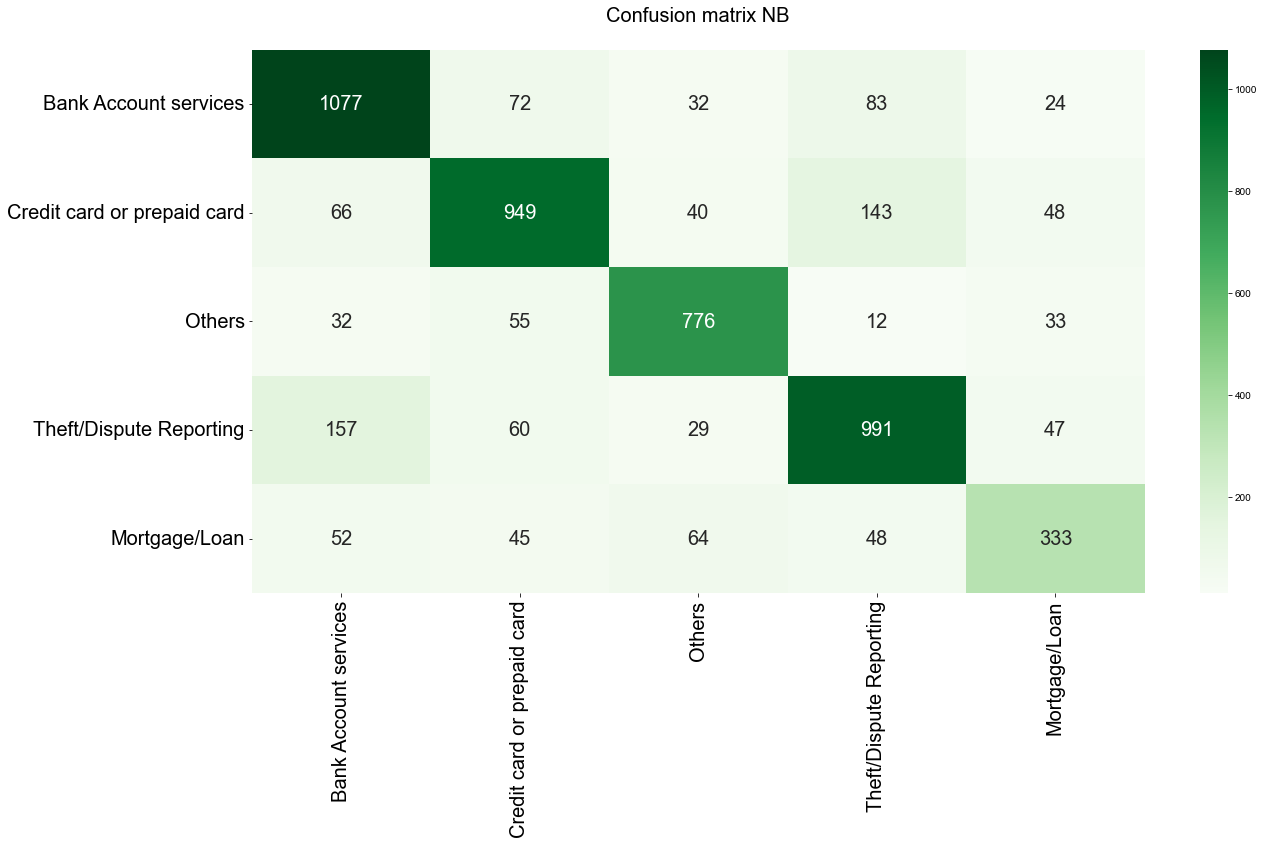

In [193]:
# Lets evaluate the NB classifier 
model_evaluation(y_test, y_pred_NB, model_name)

In [196]:
# Creating df to store f1 scores of all models
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes', 'f1 score': round(F1_score_NB_tuned, 2)}])
f1_summary

Model  f1 score
0  Naive Bayes      0.78

## 2) Logistic Regression

In [197]:
# Importing the LR alogorithm from sklearn
from sklearn.linear_model import LogisticRegression

# Initializing LR algorithm, fitting the training data and predicting on test data
model_name = 'Logistic Regression'
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [198]:
# Calculating the f1 score of model using weighted avg method
F1_score_LR = f1_score(y_test, y_pred, average='weighted')
F1_score_LR

0.9217255235034453

In [199]:
# Hyperparameter training
params_LR = {'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 

gridCV_LR = GridSearchCV(estimator=LR, param_grid=params_LR, scoring='f1_weighted', verbose=1, n_jobs=-1, cv=5)
gridCV_LR.fit(X_train, y_train)
gridCV_LR.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

In [201]:
# Creating model with best hyperparams
model_name = 'Logistic Regression'
LR_tuned = LogisticRegression(C=1, penalty='l1', solver='saga')
LR_tuned.fit(X_train, y_train)
y_pred_LR = LR_tuned.predict(X_test)

In [202]:
# Calculating the f1 score of model using weighted avg method
F1_score_LR_tuned = f1_score(y_test, y_pred_LR, average='weighted')
F1_score_LR_tuned

0.9392094693981582

Classification Report Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.95      0.94      1288
Credit card or prepaid card       0.95      0.94      0.95      1246
                     Others       0.93      0.95      0.94       908
    Theft/Dispute Reporting       0.93      0.91      0.92      1284
              Mortgage/Loan       0.94      0.95      0.95       542

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



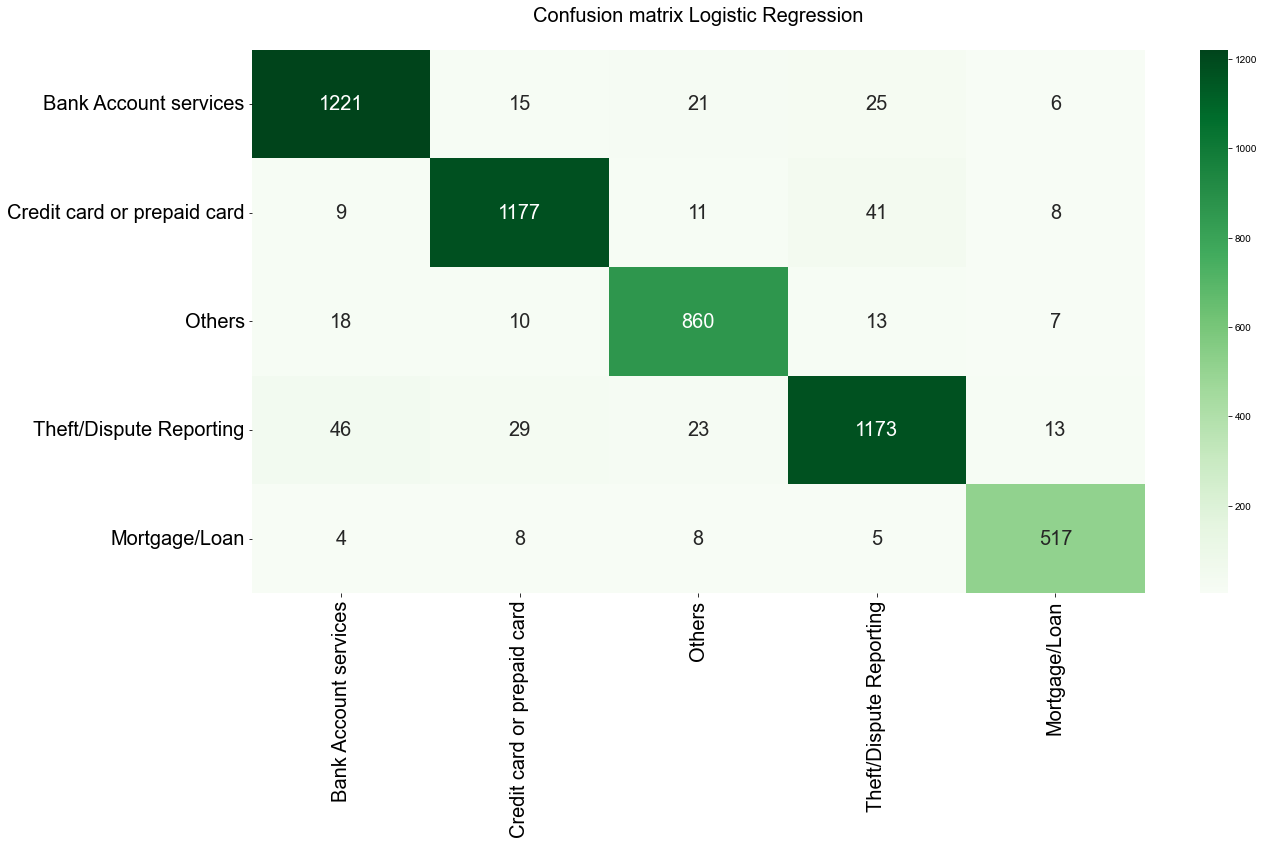

In [203]:
# Lets evaluate the LR classifier 
model_evaluation(y_test, y_pred_LR, model_name)

In [204]:
# Update the summary df
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(F1_score_LR_tuned, 2)]
f1_summary

Model  f1 score
0          Naive Bayes      0.78
1  Logistic Regression      0.94

## 3) Decision Tree

In [205]:
# Importing the DT alogorithm from sklearn
from sklearn.tree import DecisionTreeClassifier

# Initializing DT algorithm, fitting the training data and predicting on test data
model_name = 'Decision Tree'
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

In [206]:
# Calculating the f1 score of model using weighted avg method
F1_score_DT = f1_score(y_test, y_pred, average='weighted')
F1_score_DT

0.7740651332777396

In [208]:
# Hyperparameter training
params_DT = {'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15, 20, 25, 30],
            'min_samples_leaf': [1, 5, 10, 15, 20, 25]} 

gridCV_DT = GridSearchCV(estimator=DT, param_grid=params_DT, scoring='f1_weighted', verbose=1, n_jobs=-1, cv=5)
gridCV_DT.fit(X_train, y_train)
gridCV_DT.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 20}

In [209]:
# Creating model with best hyperparams
model_name = 'Decision Tree'
DT_tuned = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=20)
DT_tuned.fit(X_train, y_train)
y_pred_DT = DT_tuned.predict(X_test)

In [210]:
# Calculating the f1 score of model using weighted avg method
F1_score_DT_tuned = f1_score(y_test, y_pred_DT, average='weighted')
F1_score_DT_tuned

0.7909182590855947

Classification Report Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.82      0.80      1288
Credit card or prepaid card       0.81      0.81      0.81      1246
                     Others       0.82      0.83      0.82       908
    Theft/Dispute Reporting       0.77      0.72      0.75      1284
              Mortgage/Loan       0.79      0.77      0.78       542

                   accuracy                           0.79      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



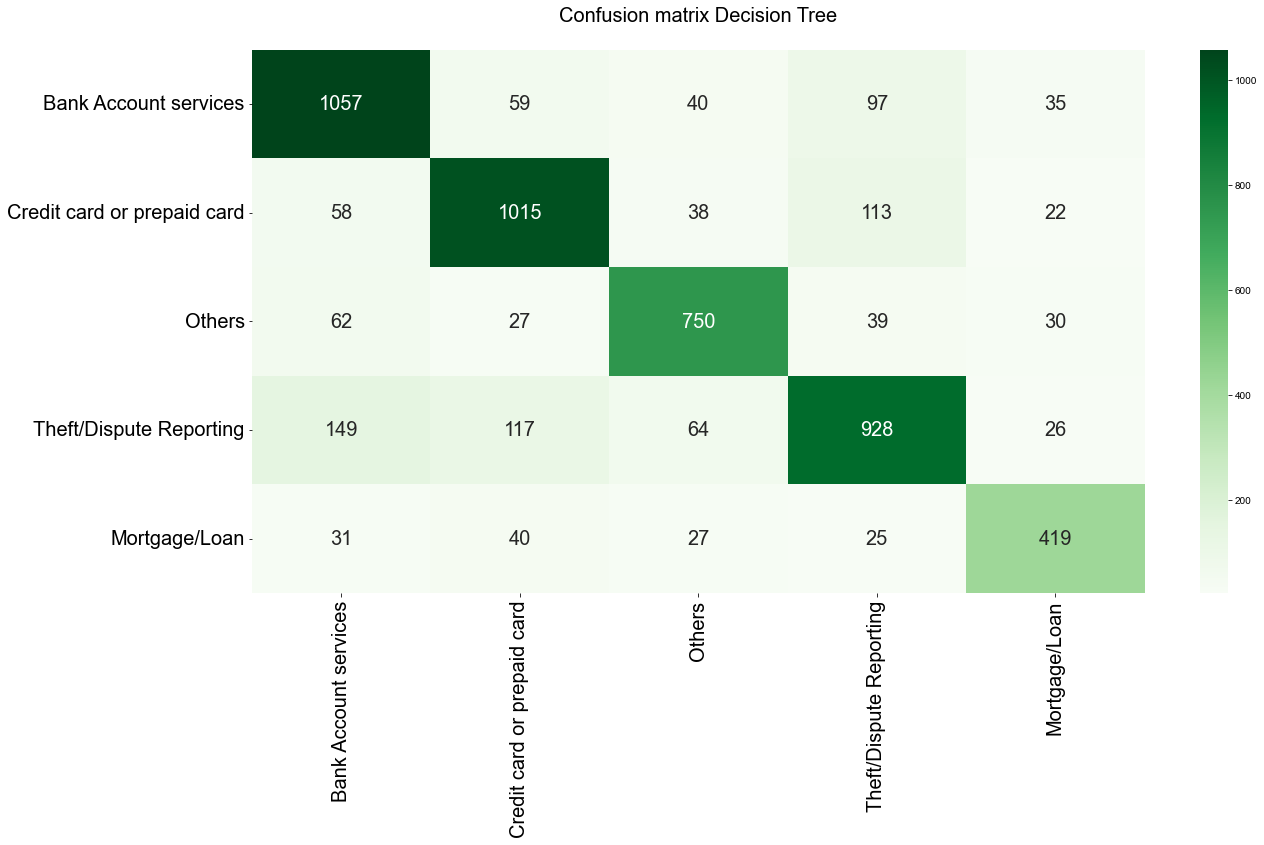

In [211]:
# Lets evaluate the DT classifier 
model_evaluation(y_test, y_pred_DT, model_name)

In [212]:
# Update the summary df
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(F1_score_DT_tuned, 2)]
f1_summary

Model  f1 score
0          Naive Bayes      0.78
1  Logistic Regression      0.94
2        Decision Tree      0.79

## 4) Random Forest

In [232]:
# Importing the RF alogorithm from sklearn
from sklearn.ensemble import RandomForestClassifier

# Initializing RF algorithm, fitting the training data and predicting on test data
model_name = 'Random Forest'
RF = RandomForestClassifier(max_depth=35)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [233]:
# Calculating the f1 score of model using weighted avg method
F1_score_RF = f1_score(y_test, y_pred_RF, average='weighted')
F1_score_RF

0.7899875523385225

Classification Report Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.89      0.84      1288
Credit card or prepaid card       0.77      0.85      0.81      1246
                     Others       0.84      0.86      0.85       908
    Theft/Dispute Reporting       0.78      0.84      0.81      1284
              Mortgage/Loan       0.96      0.31      0.47       542

                   accuracy                           0.80      5268
                  macro avg       0.83      0.75      0.76      5268
               weighted avg       0.81      0.80      0.79      5268



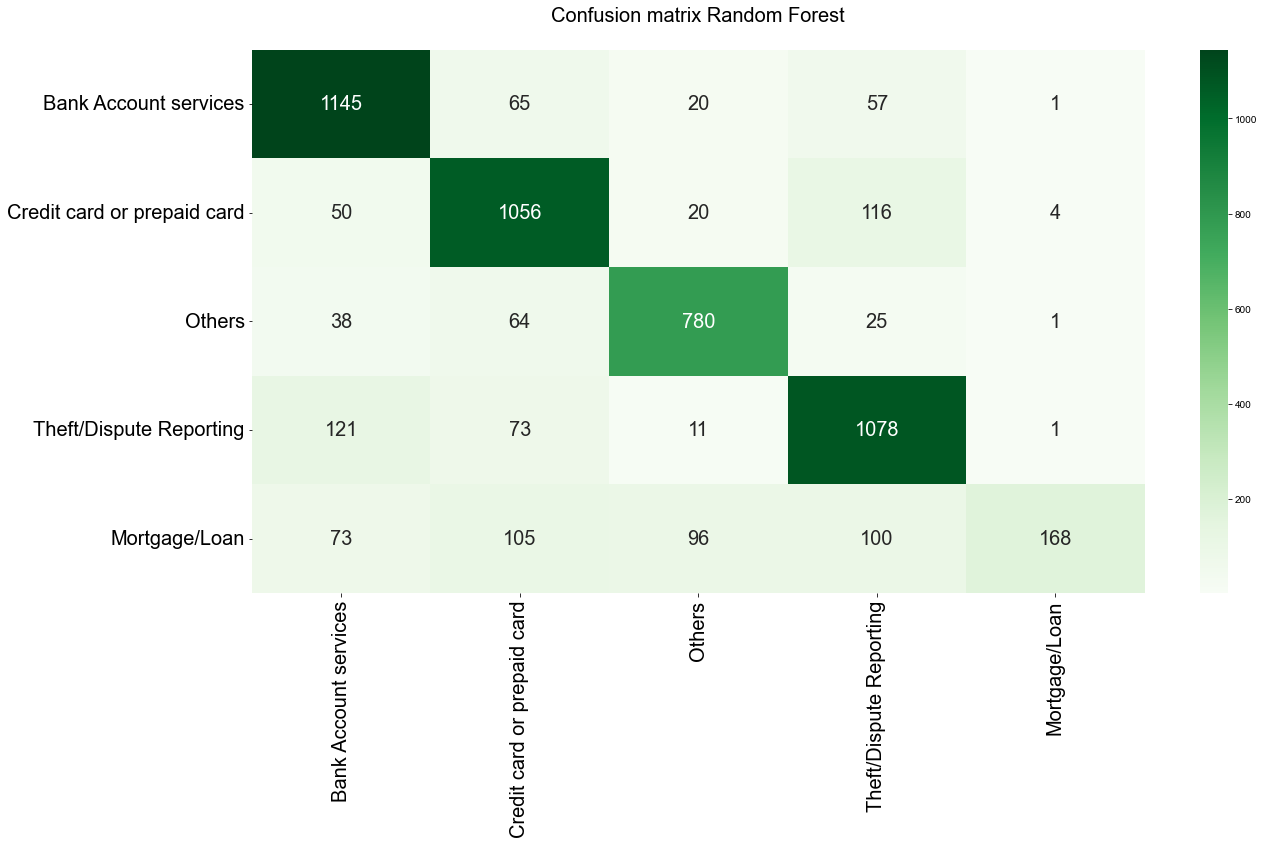

In [234]:
# Lets evaluate the RF classifier 
model_evaluation(y_test, y_pred_RF, model_name)

In [235]:
# Update the summary df
f1_summary.loc[len(f1_summary.index)] = ['Random Forest', round(F1_score_RF, 2)]
f1_summary

Model  f1 score
0          Naive Bayes      0.78
1  Logistic Regression      0.94
2        Decision Tree      0.79
3        Random Forest      0.79

## Conclusion: Logistic Regression model is predicting well with f1 score 0.94